In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from rvi_sampling.utils.stochastic_processes import create_SIR, ArbitriaryPrior, SIRParameters
import numpy as np
from collections import namedtuple
import torch.nn as nn
import torch
from rvi_sampling.stochastic_processes.base import PyTorchWrap
from rvi_sampling.samplers import RVISampler
from pg_methods.networks import MLP_factory
from pg_methods.policies import MultinomialPolicy
from pg_methods.baselines import MovingAverageBaseline, NeuralNetworkBaseline
from pg_methods.objectives import PolicyGradientObjective
A = namedtuple('bla', 'sir_seed')
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
_ = np.array([(100 - i, i, 1/(i+5)) for i in range(1, 30)])
values, probs = _[:, :2], _[:, 2]
probs /= probs.sum()

In [4]:
# prior = ArbitriaryPrior(np.array([[98, 2], [99, 1], [97, 3], [96, 4], [95, 5]]))
prior = ArbitriaryPrior(values, probs)
process_parameters = SIRParameters(100, 10, 0.9, 200, 0.01)
fake_argparser = A(0)
sir, _ = create_SIR(fake_argparser, sir_params=process_parameters, n_agents=1, prior=prior)

In [5]:
# RNN_policy = nn.Sequential(
#     nn.GRUCell(sir.state_space+int(1),hidden_size=32),
#     nn.ReLU(),
#     nn.Linear(32, sir.action_space))
# #RNN_policy(torch.autograd.Variable(torch.FloatTensor([[0, 3, 0.33]])))

In [6]:
sir.xT

array([ 0., 40.])

In [7]:
sir.new_task(), sir.xT

(array([[ 0., 32.]]), array([ 0., 32.]))

In [8]:
# create a policy for the RVI sampler
fn_approximator = MLP_factory(sir.state_space+int(1),
                              hidden_sizes=[32, 32],
                              output_size=sir.action_space,
                              hidden_non_linearity=nn.LeakyReLU)

policy = MultinomialPolicy(fn_approximator)
policy_optimizer = torch.optim.RMSprop(fn_approximator.parameters(),lr=0.0001)
# baseline = MovingAverageBaseline(0.99)

fn_approximator2 = MLP_factory(sir.state_space+int(1),
                              hidden_sizes=[16, 16],
                              output_size=1,
                              hidden_non_linearity=nn.LeakyReLU)
value_fn_optimizer = torch.optim.RMSprop(fn_approximator2.parameters(),lr=0.00001)
baseline = NeuralNetworkBaseline(fn_approximator2, value_fn_optimizer)

rvi =  RVISampler(policy,
                  policy_optimizer,
                  baseline=baseline,
                  objective=PolicyGradientObjective(entropy=10, time_mean=False),
                  feed_time=True,
                  seed=0)

In [9]:
results = rvi.solve(PyTorchWrap(sir), 5000, verbose=True)

/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:190: RuntimeWarning: divide by zero encountered in log
  step_log_probs += np.log(self.prior.pdf(self.x_agent)).reshape(-1, 1)


MC Sample 0, loss -1.06995e+06, episode_reward -129037, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -8.3713439405401


/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(step_probs)
/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: invalid value encountered in log
  step_log_probs = np.log(step_probs)


MC Sample 100, loss -3.40998e+06, episode_reward -130045, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -26.659447158221155
MC Sample 200, loss -4.77041e+06, episode_reward -140042, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -34.45752723724581
MC Sample 300, loss -781997, episode_reward -130033, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -6.155409398139454
MC Sample 400, loss -545180, episode_reward -131034, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -4.366907006828114
MC Sample 500, loss -2.51508e+06, episode_reward -126034, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -20.320268819574267
MC Sample 600, loss -1.76902e+06, episode_reward -29040.1, trajectory_length 200, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -63.20347827190976
MC Sample 700, loss -2.84012e+06, episode_rewar

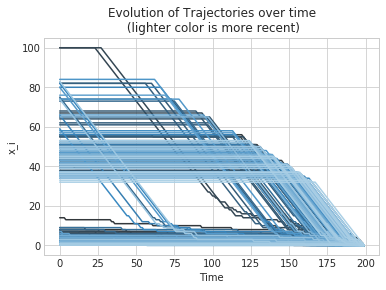

In [10]:
results.plot_all_trajectory_evolution(dimension=0)

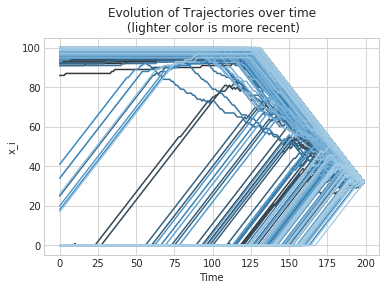

In [11]:
results.plot_all_trajectory_evolution(dimension=1)

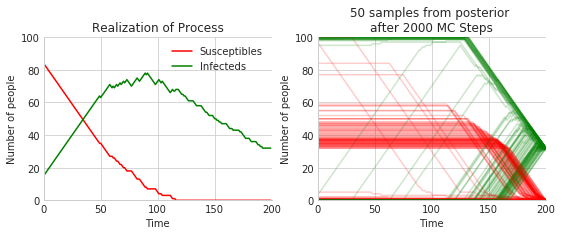

In [12]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(121)
ax.plot(sir.true_trajectory[:, 0], label='Susceptibles', color='r')
ax.plot(sir.true_trajectory[:, 1], label='Infecteds', color='g')
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('Realization of Process')

ax = fig.add_subplot(122)
for trajectory in results.all_trajectories()[-100:]:
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('50 samples from posterior \nafter 2000 MC Steps')
sns.despine()

In [25]:
state = [85, 5]
state_npy = np.array([state], dtype=np.float32)
state_pyt = np.array([state+[0.1]], dtype=np.float32)
sir.transition_prob(state_npy), nn.Softmax()(fn_approximator(torch.autograd.Variable(torch.from_numpy(state_pyt)))).data.numpy()

/home/ml/zahmed8/zaf-tmp/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


(array([[0.42500002, 0.045     , 0.52999998]]),
 array([[1.000000e+00, 7.201778e-21, 8.320848e-20]], dtype=float32))

In [16]:
timesteps = 200
xranges = 100
t, x = np.meshgrid(range(0, timesteps), range(0, xranges + 1))
list(zip(x.reshape(-1), t.reshape(-1)/t))

# for x_ in x[:, 0]:
#     vector_grid_y_arrows_t = [[] for _ in list_of_proposals]
#     for t_ in t[0, :]:
#         for proposal, vector_grid_y_arrows_t_i in zip(list_of_proposals, vector_grid_y_arrows_t):
#             if neural_network:
#                 feed_time = proposal.fn_approximator.Input.weight.size()[1] == 2
#                 vector_grid_y_arrows_t_i.append(conduct_draws_nn(proposal, float(x_), t_ / timesteps, feed_time=feed_time))
#             else:
#                 vector_grid_y_arrows_t_i.append(conduct_draws(proposal, float(x_), t_))
#     for i in range(len(vector_grid_y_arrows_t)):
#         vector_grid_y_arrows[i].append(vector_grid_y_arrows_t[i])

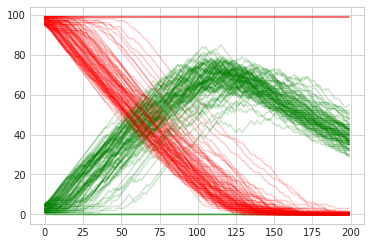

In [121]:
for i in range(100):
    trajectory = sir.simulate()
    plt.plot(trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    plt.plot(trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
#     plt.plot(sir.population_size - trajectory[:, 0] - trajectory[:, 1], label='recoveries', color='b', alpha=0.2)
